In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from tools import *

%matplotlib inline

In [2]:
raw_results = list()
for filename in ['results/2019-10-01T16:46:19.017259-04:00.json',
                 'results/2019-10-02T16:07:35.437936-04:00.json',
                 'results/2019-10-03T10:35:40.202709-04:00.json']:
    with open(filename, 'r') as infile:
        raw_results += json.load(infile)
results = list_of_dicts_to_dict_of_lists(raw_results)
for key, value in results.items():
    results[key] = to_nested_tuples(value)
results = pd.DataFrame(data=results)
masks = pd.read_csv('mnist_masks.csv')

In [3]:
rdf = results.copy(deep=True)
rdf = rdf[rdf['success']]
for i in rdf.index:
    if (rdf.at[i, 'optimizer'] == 'sgd') and (str(rdf.at[i, 'momentum']) != '0.0'):
        rdf.at[i, 'optimizer'] = 'momentum'

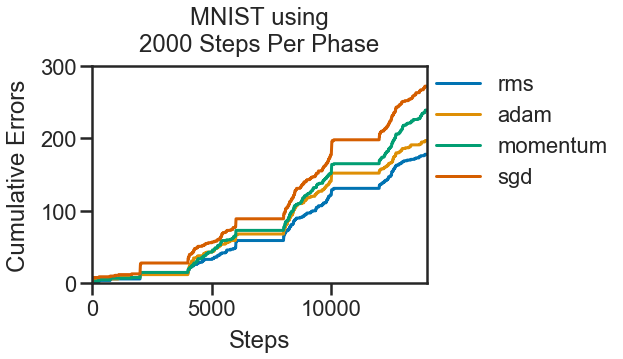

In [4]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'steps') &
                                        (rdf['dataset'] == 'mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 14000)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 300)
plt.title('MNIST using\n2000 Steps Per Phase', pad=15)
plt.savefig('mnist_steps.pdf', bbox_inches='tight')

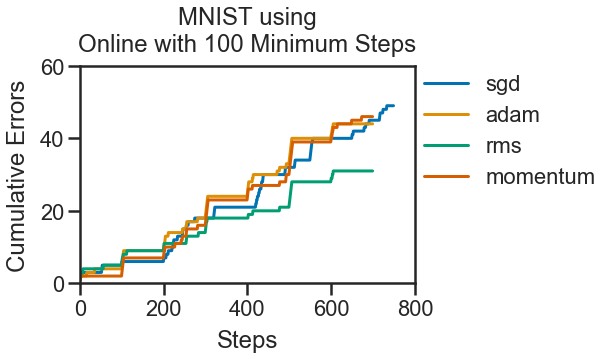

In [5]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 100) &
                                        (rdf['dataset'] == 'mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 800)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('MNIST using\nOnline with 100 Minimum Steps', pad=15)
plt.savefig('mnist_online_100.pdf', bbox_inches='tight')

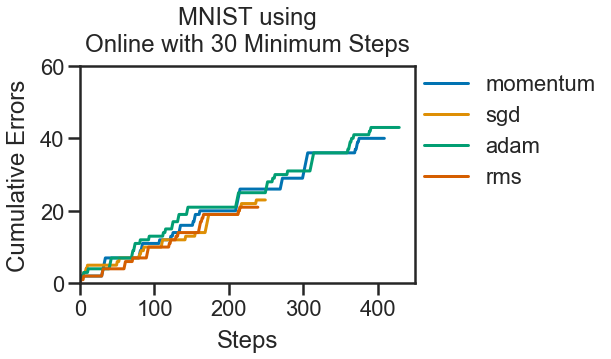

In [6]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 30) &
                                        (rdf['dataset'] == 'mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 450)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('MNIST using\nOnline with 30 Minimum Steps', pad=15)
plt.savefig('mnist_online_30.pdf', bbox_inches='tight')

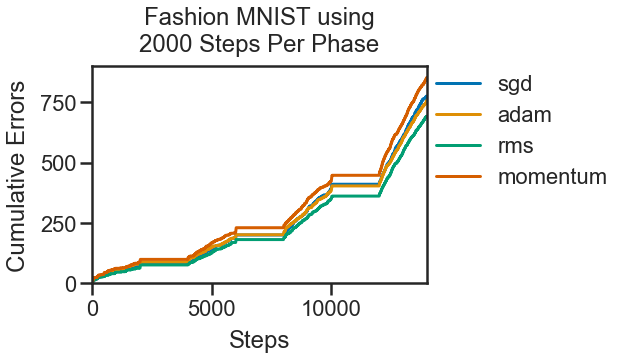

In [7]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'steps') &
                                        (rdf['dataset'] == 'fashion_mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 14000)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 900)
plt.title('Fashion MNIST using\n2000 Steps Per Phase', pad=15)
plt.savefig('fashion_mnist_steps.pdf', bbox_inches='tight')

In [ ]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 100) &
                                        (rdf['dataset'] == 'fashion_mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 800)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('Fashion MNIST using\nOnline with 100 Minimum Steps', pad=15)
plt.savefig('fashion_mnist_online_100.pdf', bbox_inches='tight')

In [ ]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 30) &
                                        (rdf['dataset'] == 'fashion_mnist')])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 450)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('Fashion MNIST using\nOnline with 30 Minimum Steps', pad=15)
plt.savefig('fashion_mnist_online_30.pdf', bbox_inches='tight')